<a href="https://colab.research.google.com/github/Shankar-Hadimani/ai-ml-engineering/blob/master/sentiment_analysis_GBM_H2O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
openjdk version "11.0.9" 2020-10-20
OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)


In [2]:
!pip install h2o==3.30.0.1

     |████████████████████████████████| 129.5MB 72kB/s 
  Created wheel for h2o: filename=h2o-3.30.0.1-py2.py3-none-any.whl size=129557718 sha256=f4fd23ae6c911482f8afefd7b03ec1b7f0282f8e3ddd59dd1d75559d5634e26b
  Stored in directory: /root/.cache/pip/wheels/db/42/63/d118d7218432054da842f5d10bd4f99e978bde0931164e6c7a
Successfully built h2o


In [3]:
import tensorflow_datasets as tfds
import h2o
import numpy as np


In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9" 2020-10-20; OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvnxce23c
  JVM stdout: /tmp/tmpvnxce23c/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpvnxce23c/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,7 months and 6 days !!!
H2O_cluster_name:,H2O_from_python_unknownUser_k2l2e4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [5]:
dataset, info  = tfds.load('amazon_us_reviews/Personal_Care_Appliances_v1_00', with_info=True, batch_size=-1)
train_dataset = dataset['train']

Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Personal_Care_Appliances_v1_00/0.1.0.incomplete3ZO2MV/amazon_us_reviews-train.tfrecord


Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Personal_Care_Appliances_v1_00/0.1.0. Subsequent calls will reuse this data.


In [6]:
info

tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    version=0.1.0,
    description='Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

Over 130+ million cus

In [7]:
### convert the tensors into numpy. 
# To run any GBM or any reggular ML model, we need it to be in numpy
dataset = tfds.as_numpy(train_dataset)

In [8]:
dataset

{'data': {'customer_id': array([b'13986323', b'50574716', b'50593972', ..., b'40719682',
         b'35596948', b'29430209'], dtype=object),
  'helpful_votes': array([0, 3, 0, ..., 0, 0, 0], dtype=int32),
  'marketplace': array([b'US', b'US', b'US', ..., b'US', b'US', b'US'], dtype=object),
  'product_category': array([b'Personal_Care_Appliances', b'Personal_Care_Appliances',
         b'Personal_Care_Appliances', ..., b'Personal_Care_Appliances',
         b'Personal_Care_Appliances', b'Personal_Care_Appliances'],
        dtype=object),
  'product_id': array([b'B00847JQZ6', b'B00N5HD340', b'B0077L1X24', ..., b'B000UZ8X2W',
         b'B000NURPPK', b'B001EY5GNW'], dtype=object),
  'product_parent': array([b'997683625', b'955577225', b'120764066', ..., b'96066145',
         b'58591097', b'986877728'], dtype=object),
  'product_title': array([b'SE - Reading Glass - Spring Loaded Hinges, 4.0x - RTS62400',
         b'Straight Razor',
         b'Philips Sonicare Flexcare & Healthy White Plastic

In [9]:
helpful_votes=dataset['data']['helpful_votes']
review_headline=dataset['data']['review_headline']
review_body=dataset['data']['review_body']
star_rating=dataset['data']['star_rating']

In [10]:
### convert each feature sinto an H2o Dataframe 
h2o_df = h2o.H2OFrame(np.hstack((helpful_votes[:,None],review_headline[:,None],review_body[:,None],star_rating[:,None])),
                      column_names=['votes','headline','reviews','rating'],
                      column_types=['numeric','string','string','numeric']
                      )

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [11]:
h2o_df.head()

votes,headline,reviews,rating
0,b'These glasses are an excellent value. The fit is good and they are ...',"b""These glasses are an excellent value. The fit is good and they are very comfortable. Because of my legal blindness, there aren't a lot of options to try to see better, but I believe these help with my other visual aids, and because they are reasonably priced I can have more than one pair available.""",4
3,b'A fantastic way to cheaply try straight razor shaving.',"b""Always wanted to try straight razor shaving (as a DE safety razor user), and this was a cheap way for me to determine I was not into it.<br /><br />Because the blades are disposable and always sharp, I could put a new one in and reasonably rely upon that fact that cuts were probably due to my technique and not the blade.<br /><br />It's very hard to do straight razor shaving on yourself because the ANGLE is difficult to control without switching hands. Being very right-handed, I really couldn't do that. I bet I could shave someone else's face with it though.<br /><br />An immediate upside? Using a DE safety razor (slant edged even) seems SUPER safe now! I'm increased my speed with the DE due to that confidence, and I'd been using it for years now.""",5
0,b'Great for travel',"b'I usually either throw my toothbrush in a plastic bag with spare head so this product is very convenient for keeping all the parts apart, dry and undamaged, and i now keep it in my travel bag all the time ready to go.'",4
0,b'Five Stars',b'Top quality.',5
1,b'*Product sent not as shown',"b'Today I received 1 Fl. Oz, Natures Balance AlkaMAX alkaline booster liquid unflavored (formally TriMedica) a glass brown bottle with eye dropper.<br />Supplement Facts; Serving Size: 10 Drops (Approx. 0.5 mL). Servings per Container: Approx. 60<br />Amount Per Serving % Daily Value<br />Magnesium (as Magnesium Chloride) 40 mg 10%<br />Chloride (as Magnesium Chloride) 64 mg 2%<br />Other Ingredients: Deionized water and trace mineral complex.<br />Directions: Add 10 drops to 8 oz. of water or other beverage daily as needed or as directed by your health care practitioner. Store in a cool, dry place.<br /><br />I have not used product as of yet with changed ingredients of original/as shown in AlkaMax alkaline support white squeeze bottle.<br />but had to rate to post...heck this new may be better for all I know.'",3
6,b'Seems to work well!',"b'I recently picked this unit up at Bed and Bath where it was $99.00. With a 20% coupon the price was $80 (so comparison shop!) It\'s easy to use and seems to work well. I agree with other reviewers about the noise level (loud like a tea kettle boiling), but I use this unit in the living room area so sleeping is not an issue. Having the 2 separate water reservoirs to fill is much easier, weight-wise, as I previously had another humidifier which had one large water reservoir and it was very heavy when full. The unit comes apart quite easily for cleaning and since frequent cleaning is recommended (I usually do it 1x per week, not daily) this is a definite plus. Additionally, one only needs to use vinegar to clean the inside reservoir, which is a lot cheaper than having to buy some kind of \\\\""special\\\\"" cleaning solution. My one complaint is that it doesn\'t, but should, have an automatic shut off when both tanks are empty.I have to remember to turn the unit off when I leave the house. My previous humidifiers all had this auto turn off; seems like every humidifier should.'",4
8,b'deep heat?????',"b'Not sure what previous reviewer was talking about. The product uses ULTRASOUND waves for pain relief NOT heat. After repeated use, the pain in my knee and shoulder was feeling great. I think you should re-read the description and reconsider your opinion. Great product sold by a great company.'",5
2,b'Thermometer for a toddler',"b""The shippers were great....willing to consider speedier shipping options, but in the end the standard shipping arrived quickly enough. The 

In [12]:
### we can have it as mulli-classification problem. but for this analysis, it will either or positive sentiment
### makingit binary classification problem 
h2o_df['target']=(h2o_df['rating']>=4).ifelse("1","0")

In [13]:
h2o_df.head()

votes,headline,reviews,rating,target
0,b'These glasses are an excellent value. The fit is good and they are ...',"b""These glasses are an excellent value. The fit is good and they are very comfortable. Because of my legal blindness, there aren't a lot of options to try to see better, but I believe these help with my other visual aids, and because they are reasonably priced I can have more than one pair available.""",4,1
3,b'A fantastic way to cheaply try straight razor shaving.',"b""Always wanted to try straight razor shaving (as a DE safety razor user), and this was a cheap way for me to determine I was not into it.<br /><br />Because the blades are disposable and always sharp, I could put a new one in and reasonably rely upon that fact that cuts were probably due to my technique and not the blade.<br /><br />It's very hard to do straight razor shaving on yourself because the ANGLE is difficult to control without switching hands. Being very right-handed, I really couldn't do that. I bet I could shave someone else's face with it though.<br /><br />An immediate upside? Using a DE safety razor (slant edged even) seems SUPER safe now! I'm increased my speed with the DE due to that confidence, and I'd been using it for years now.""",5,1
0,b'Great for travel',"b'I usually either throw my toothbrush in a plastic bag with spare head so this product is very convenient for keeping all the parts apart, dry and undamaged, and i now keep it in my travel bag all the time ready to go.'",4,1
0,b'Five Stars',b'Top quality.',5,1
1,b'*Product sent not as shown',"b'Today I received 1 Fl. Oz, Natures Balance AlkaMAX alkaline booster liquid unflavored (formally TriMedica) a glass brown bottle with eye dropper.<br />Supplement Facts; Serving Size: 10 Drops (Approx. 0.5 mL). Servings per Container: Approx. 60<br />Amount Per Serving % Daily Value<br />Magnesium (as Magnesium Chloride) 40 mg 10%<br />Chloride (as Magnesium Chloride) 64 mg 2%<br />Other Ingredients: Deionized water and trace mineral complex.<br />Directions: Add 10 drops to 8 oz. of water or other beverage daily as needed or as directed by your health care practitioner. Store in a cool, dry place.<br /><br />I have not used product as of yet with changed ingredients of original/as shown in AlkaMax alkaline support white squeeze bottle.<br />but had to rate to post...heck this new may be better for all I know.'",3,0
6,b'Seems to work well!',"b'I recently picked this unit up at Bed and Bath where it was $99.00. With a 20% coupon the price was $80 (so comparison shop!) It\'s easy to use and seems to work well. I agree with other reviewers about the noise level (loud like a tea kettle boiling), but I use this unit in the living room area so sleeping is not an issue. Having the 2 separate water reservoirs to fill is much easier, weight-wise, as I previously had another humidifier which had one large water reservoir and it was very heavy when full. The unit comes apart quite easily for cleaning and since frequent cleaning is recommended (I usually do it 1x per week, not daily) this is a definite plus. Additionally, one only needs to use vinegar to clean the inside reservoir, which is a lot cheaper than having to buy some kind of \\\\""special\\\\"" cleaning solution. My one complaint is that it doesn\'t, but should, have an automatic shut off when both tanks are empty.I have to remember to turn the unit off when I leave the house. My previous humidifiers all had this auto turn off; seems like every humidifier should.'",4,1
8,b'deep heat?????',"b'Not sure what previous reviewer was talking about. The product uses ULTRASOUND waves for pain relief NOT heat. After repeated use, the pain in my knee and shoulder was feeling great. I think you should re-read the description and reconsider your opinion. Great product sold by a great company.'",5,1
2,b'Thermometer for a toddler',"b""The shippers were great....willing to consider speedier shipping options, but in the end the standard shipping arrived

In [14]:
h2o_df.shape

(85981, 5)

In [15]:
### view the data distribution for each classifcation
h2o_df['target'].table()

target,Count
0,23427
1,62554


In [16]:
h2o_df.describe()

Rows:85981
Cols:5




,votes,headline,reviews,rating,target
type,int,string,string,int,enum
mins,0.0,NaN,NaN,1.0,
mean,3.3494841883672,NaN,NaN,3.977401984159291,
maxs,2785.0,NaN,NaN,5.0,
sigma,19.483167220712946,NaN,NaN,1.433130291971473,
zeros,44555,0,0,0,
missing,0,0,0,0,0
0,0.0,b'These glasses are an excellent value. The fit is good and they are ...',"b""These glasses are an excellent value. The fit is good and they are very comfortable. Because of my legal blindness, there aren't a lot of options to try to see better, but I believe these help with my other visual aids, and because they are reasonably priced I can have more than one pair available.""",4.0,1
1,3.0,b'A fantastic way to cheaply try straight razor shaving.',"b""Always wanted to try straight razor shaving (as a DE safety razor user), and this was a cheap way for me to determine I was not into it.<br /><br />Because the blades are disposable and always sharp, I could put a new one in and reasonably rely upon that fact that cuts were probably due to my technique and not the blade.<br /><br />It's very hard to do straight razor shaving on yourself because the ANGLE is difficult to control without switching hands. Being very right-handed, I really couldn't do that. I bet I could shave someone else's face with it though.<br /><br />An immediate upside? Using a DE safety razor (slant edged even) seems SUPER safe now! I'm increased my speed with the DE due to that confidence, and I'd been using it for years now.""",5.0,1
2,0.0,b'Great for travel',"b'I usually either throw my toothbrush in a plastic bag with spare head so this product is very convenient for keeping all the parts apart, dry and undamaged, and i now keep it in my travel bag all the time ready to go.'",4.0,1


In [17]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
def tokenize(line):
  tokenized = line.tokenize("\\W+")
  tokenized = tokenized.tolower()
  tokenized = tokenized[(tokenized.nchar() >= 2) | (tokenized.isna()),:]
  tokenized_filter = tokenized[(tokenized.isna()) | (~ tokenized.isin(stopwords)),:]
  return tokenized

In [19]:
review_words = tokenize(h2o_df['reviews'])

In [20]:
headline_words = tokenize(h2o_df['headline'])

In [21]:
review_words.head()

C1
these
glasses
are
an
excellent
value
the
fit
is
good


In [22]:
headline_words.head()

C1
these
glasses
are
an
excellent
value
the
fit
is
good


In [23]:
review_words.shape

(5273828, 1)

In [24]:
headline_words.shape

(420948, 1)

In [25]:
### apply word embedding, to preoduce dictionary of vectors for each words
from h2o.estimators.word2vec import H2OWord2vecEstimator
from h2o.estimators import H2OGradientBoostingEstimator, H2OXGBoostEstimator

### define vector size 
vector_size = 100
modelId = 'w2v_amazon.model'

In [26]:
### apply the embedding via word2vec, to create vecotrs for eahc words 

vec_model = H2OWord2vecEstimator(vec_size = vector_size, model_id = modelId)
vec_model.train(training_frame=review_words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [27]:
### save the word to vecotr model onto home local current directory
h2o.save_model(vec_model, path='./', force=True)

'/content/w2v_amazon.model'

In [28]:
### load the above created model
vec_model=h2o.load_model('w2v_amazon.model')

In [29]:
### verify the word2vecotrs for some of the words
vec_model.find_synonyms("perfumes", count=5)

OrderedDict([('scents', 0.673536479473114),
             ('shampoos', 0.6668650507926941),
             ('fragrances', 0.6611550450325012),
             ('dyes', 0.6491435170173645),
             ('odor', 0.6470993161201477)])

In [30]:
vec_model.find_synonyms("toothpaste", count=5)

OrderedDict([('listerine', 0.7461536526679993),
             ('mouthwash', 0.7360334396362305),
             ('plax', 0.6893804669380188),
             ('mentadent', 0.6744933724403381),
             ('peroxide', 0.6492474675178528)])

In [31]:
vec_model.find_synonyms("glasses", count=5)

OrderedDict([('sunglasses', 0.8603562712669373),
             ('readers', 0.8181847929954529),
             ('lenses', 0.793648898601532),
             ('frames', 0.7778485417366028),
             ('bifocal', 0.7615526914596558)])

In [33]:
### apply the transform on to the model
review_vectors = vec_model.transform(words=review_words, aggregate_method='AVERAGE')

In [34]:
review_vectors.head()

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.137222,0.115583,0.172219,0.0569763,0.0792718,-0.0701947,-0.0574682,0.264816,-0.126841,0.0372701,0.0197006,0.04092,0.0689601,0.00691406,0.0520193,-0.0504224,0.103814,0.0261062,0.130535,0.0752233,-0.0213316,-0.256437,-0.00447832,-0.0688431,0.000506429,0.0562167,-0.00107106,0.118595,-0.217802,0.0803445,-0.0190915,-0.0557879,-0.0700754,0.0153211,0.106421,-0.0489717,-0.0587561,0.0918784,0.0225978,0.0677318,-0.0953665,-0.0233423,-0.0789354,0.183255,0.0455004,0.0384083,-0.0595764,-0.0394668,-0.0627003,-0.141261,0.144207,-0.0641221,-0.0288916,0.0214352,-0.025104,0.103534,-0.0183493,-0.0114785,0.0478604,0.117643,0.111063,-0.165793,0.071179,0.0147723,0.0165586,-0.0653587,0.082973,-0.0143014,-0.0336733,0.0505101,0.0633497,0.050679,0.0828305,0.0717191,0.0174651,-0.0121581,0.152695,-0.0676394,0.0428186,0.0194882,0.00968325,-0.0384011,-0.0671563,-0.0351003,0.0843942,-0.0475753,0.0310518,0.0518132,0.0302793,0.0365999,0.0524276,-0.0633831,-0.0216948,0.192114,-0.0802923,-0.179052,-0.172212,-0.0419707,0.164748,0.0411342
0.122692,0.108548,0.0928803,0.0120673,0.0464922,-0.0562122,-0.0656326,0.215495,-0.0165786,-0.00645024,-0.0161077,0.0658393,0.0139666,0.0877592,0.00472991,0.0330163,0.02561,0.0339216,0.0449717,0.0273878,-0.0510797,-0.295671,-0.0612232,-0.0128371,0.0769703,-0.0372176,-0.0159504,0.0999549,-0.221537,0.0809917,0.0547917,-0.0280364,-0.0960602,-0.0544372,0.0443664,-0.0296253,-0.0912359,0.0930491,0.10542,0.0479294,-0.0699413,0.0652917,-0.0653718,0.165309,0.0470647,-0.121329,-0.00692901,0.0364388,-0.122898,-0.12759,0.208731,-0.0888714,0.00556658,0.0340843,-0.0223497,0.144821,-0.0894943,0.00871597,0.0882565,0.0918612,0.0135239,-0.0881577,0.0778562,0.00688536,-0.0300894,-0.0129628,0.109207,-0.0217277,-0.0863877,0.0651518,0.0470751,0.0137142,0.117338,-0.035471,-0.034892,0.074157,0.12689,-0.0795374,0.00893092,0.0284777,0.111314,-0.0171356,-0.0786387,-0.145153,0.0279958,-0.0857467,0.104402,0.128696,0.0690357,0.0205333,0.0194737,-0.00615596,0.0947211,0.115763,-0.0871309,-0.0839445,-0.0791118,0.0481745,0.0663742,0.0809002
0.142968,0.0742791,0.160406,0.0114594,0.12253,-0.0872727,-0.0699563,0.168077,-0.0218188,0.0723845,-0.0512826,0.139991,0.0569815,0.103654,0.0149677,-0.023958,0.0338745,-0.0825918,0.0968323,0.0553449,0.000686409,-0.178395,-0.0321664,0.0117005,0.00898672,-0.0525435,0.026963,0.16446,-0.164534,0.0612147,0.00892821,0.0029699,-0.108288,-0.0470918,0.0313289,-0.078487,-0.035496,0.0247479,0.0540638,-0.0170584,-0.033797,-0.00777416,-0.0116633,0.125645,-0.00118757,-0.0379382,-0.0545512,-0.0113112,-0.0882311,-0.114609,0.144785,-0.0988031,-0.00627526,0.102101,-0.0330474,0.117139,-0.0341278,-0.047236,0.0302714,0.188194,0.0177518,-0.0591799,0.157737,0.0216347,-0.065269,-0.0580102,0.0581487,0.0316922,-0.102229,-0.0123889,0.0969897,0.0857195,0.0278306,0.104052,-0.0566447,0.0266112,0.0960539,-0.0758801,0.0332453,-0.0144418,0.169762,-0.0636586,0.0265121,-0.19488,0.0772886,-0.015011,0.109137,0.0887782,0.0466339,0.102586,0.0670452,-0.163695,-0.0127398,0.167928,-0.0896176,-0.164553,-0.0550749,0.0176373,0.157681,0.11683
0.2096,0.177676,0.276516,-0.213128,-0.045182,-0.0748436,-0.188679,0.267056,-0.123235,-0.123182,0.204238,0.157368,0.103422,0.0577136,-0.0310706,-0.156878,-0.00129108,0.0920107,0.102773,-0.15345,-0.274706,-0.21033,0.0920886,-0.0583911,-0.0695628,0.184897,-0.175097,0.150086,-0.48452,0.0855363,-0.055192,-0.0244086,0.102094,0.145785,0.0128132,-0.102625,-0.20956,-0.0859426,-0.163133,0.355339,-0.0124848,-0.0266485,-0.189644,-0.0136696,-0.13802,0.0118813,0.136061,-0.146467,-0.222834,0.174656,0.175275,-0.212595,0.154557,0.00873826,0.206605,-0.00236053,0.020

In [35]:
review_vectors.shape

(85981, 100)

In [37]:
h2o_extended_df =h2o_df.cbind(review_vectors)

In [38]:
### bind and extend the original H2o Dataframe
h2o_extended_df.head()

votes,headline,reviews,rating,target,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0,b'These glasses are an excellent value. The fit is good and they are ...',"b""These glasses are an excellent value. The fit is good and they are very comfortable. Because of my legal blindness, there aren't a lot of options to try to see better, but I believe these help with my other visual aids, and because they are reasonably priced I can have more than one pair available.""",4,1,0.137222,0.115583,0.172219,0.0569763,0.0792718,-0.0701947,-0.0574682,0.264816,-0.126841,0.0372701,0.0197006,0.04092,0.0689601,0.00691406,0.0520193,-0.0504224,0.103814,0.0261062,0.130535,0.0752233,-0.0213316,-0.256437,-0.00447832,-0.0688431,0.000506429,0.0562167,-0.00107106,0.118595,-0.217802,0.0803445,-0.0190915,-0.0557879,-0.0700754,0.0153211,0.106421,-0.0489717,-0.0587561,0.0918784,0.0225978,0.0677318,-0.0953665,-0.0233423,-0.0789354,0.183255,0.0455004,0.0384083,-0.0595764,-0.0394668,-0.0627003,-0.141261,0.144207,-0.0641221,-0.0288916,0.0214352,-0.025104,0.103534,-0.0183493,-0.0114785,0.0478604,0.117643,0.111063,-0.165793,0.071179,0.0147723,0.0165586,-0.0653587,0.082973,-0.0143014,-0.0336733,0.0505101,0.0633497,0.050679,0.0828305,0.0717191,0.0174651,-0.0121581,0.152695,-0.0676394,0.0428186,0.0194882,0.00968325,-0.0384011,-0.0671563,-0.0351003,0.0843942,-0.0475753,0.0310518,0.0518132,0.0302793,0.0365999,0.0524276,-0.0633831,-0.0216948,0.192114,-0.0802923,-0.179052,-0.172212,-0.0419707,0.164748,0.0411342
3,b'A fantastic way to cheaply try straight razor shaving.',"b""Always wanted to try straight razor shaving (as a DE safety razor user), and this was a cheap way for me to determine I was not into it.<br /><br />Because the blades are disposable and always sharp, I could put a new one in and reasonably rely upon that fact that cuts were probably due to my technique and not the blade.<br /><br />It's very hard to do straight razor shaving on yourself because the ANGLE is difficult to control without switching hands. Being very right-handed, I really couldn't do that. I bet I could shave someone else's face with it though.<br /><br />An immediate upside? Using a DE safety razor (slant edged even) seems SUPER safe now! I'm increased my speed with the DE due to that confidence, and I'd been using it for years now.""",5,1,0.122692,0.108548,0.0928803,0.0120673,0.0464922,-0.0562122,-0.0656326,0.215495,-0.0165786,-0.00645024,-0.0161077,0.0658393,0.0139666,0.0877592,0.00472991,0.0330163,0.02561,0.0339216,0.0449717,0.0273878,-0.0510797,-0.295671,-0.0612232,-0.0128371,0.0769703,-0.0372176,-0.0159504,0.0999549,-0.221537,0.0809917,0.0547917,-0.0280364,-0.0960602,-0.0544372,0.0443664,-0.0296253,-0.0912359,0.0930491,0.10542,0.0479294,-0.0699413,0.0652917,-0.0653718,0.165309,0.0470647,-0.121329,-0.00692901,0.0364388,-0.122898,-0.12759,0.208731,-0.0888714,0.00556658,0.0340843,-0.0223497,0.144821,-0.0894943,0.00871597,0.0882565,0.0918612,0.0135239,-0.0881577,0.0778562,0.00688536,-0.0300894,-0.0129628,0.109207,-0.0217277,-0.0863877,0.0651518,0.0470751,0.0137142,0.117338,-0.035471,-0.034892,0.074157,0.12689,-0.0795374,0.00893092,0.0284777,0.111314,-0.0171356,-0.0786387,-0.145153,0.0279958,-0.0857467,0.104402,0.128696,0.0690357,0.0205333,0.0194737,-0.00615596,0.0947211,0.115763,-0.0871309,-0.0839445,-0.0791118,0.0481745,0.0663742,0.0809002
0,b'Great for travel',"b'I usually either throw my toothbrush in a plastic bag with spare head so this product is very convenient for keeping all the parts apart, dry and undamaged, and i now keep it in my travel bag all the time ready to go.'",4,1,0.142968,0.0742791,0.160406,0.0114594,0.12253,-0.0872727,-0.0699

In [43]:
### split the xtended h2o dataframe between 80-20 ration between train and validation dataset
h2o_train, h2o_valid = h2o_extended_df.split_frame(ratios=[0.8])

In [45]:
### check the distributuin of validation dataset
h2o_valid['target'].table()

target,Count
0,4765
1,12501


In [46]:
### instantiate the GBM baseline model
### with stopping tolerance of 0.001 between last 5 rounds of training 
gbm_baseline = H2OGradientBoostingEstimator(stopping_metric='AUC', 
                                            stopping_tolerance=0.001,
                                            stopping_rounds=5,
                                            score_tree_interval=10)

In [47]:
### train the model with h20_train dataset with column names from original 
### review vectors(c1--> c100) and yhat being 'target' classifier column
gbm_baseline.train(x=review_vectors.names, y='target', training_frame=h2o_train, validation_frame=h2o_valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [48]:
### verify the Area under curve from the above trained dataset
print('Baselined AUC:  ' + str(round(gbm_baseline.auc(valid=True), 3)))

Baselined AUC:  0.886


In [49]:
### check the confusion matrix for under and over fitting
gbm_baseline.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.541041407871051: 


,,0,1,Error,Rate
0,0,2776.0,1989.0,0.4174,(1989.0/4765.0)
1,1,848.0,11653.0,0.0678,(848.0/12501.0)
2,Total,3624.0,13642.0,0.1643,(2837.0/17266.0)


In [51]:
### instantiate H2o GradientBoosting estimator, with Balanced classes/distribution
### along with 0.001 tolerance for last 5 rounds of training
gbm_balanced = H2OGradientBoostingEstimator(stopping_metric='AUC',
                                            stopping_tolerance=0.001,
                                            stopping_rounds=5,
                                            score_tree_interval=10,
                                            balance_classes=True)

In [53]:
### train again, with balanced classes
gbm_balanced.train(x=review_vectors.names, y='target', training_frame=h2o_train, validation_frame=h2o_valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
### print again the AUC for balanced classes. no guarntee but better to validat this balanced class might 
###return better than unbalanced
print('Balanced GBM AUC: '+ str(round(gbm_balanced.auc(valid=True),3))) 

Balanced GBM AUC: 0.886


In [55]:
### check the confusion matrix for under and over fitting
gbm_balanced.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5439243497810086: 


,,0,1,Error,Rate
0,0,2650.0,2115.0,0.4439,(2115.0/4765.0)
1,1,781.0,11720.0,0.0625,(781.0/12501.0)
2,Total,3431.0,13835.0,0.1677,(2896.0/17266.0)


# #*Out Come from above Model:*  Not much difference between balanced v/s baseline GBM model. Looking at confusion matrix, error got increased with '0' classification in balanced model*
-----------------------------------------------------------------------







In [89]:
### let's add review headline texts

#### create a headline vector using word2Vec 
##### append prefix 'headline_' to the each column for identfication
headline_vectors = vec_model.transform(headline_words, aggregate_method='AVERAGE')
headline_vectors.names = ['headline_' +  col for col in headline_vectors.names]

In [90]:
headline_words.head()

C1
these
glasses
are
an
excellent
value
the
fit
is
good


In [91]:
headline_vectors.head()

headline_C1,headline_C2,headline_C3,headline_C4,headline_C5,headline_C6,headline_C7,headline_C8,headline_C9,headline_C10,headline_C11,headline_C12,headline_C13,headline_C14,headline_C15,headline_C16,headline_C17,headline_C18,headline_C19,headline_C20,headline_C21,headline_C22,headline_C23,headline_C24,headline_C25,headline_C26,headline_C27,headline_C28,headline_C29,headline_C30,headline_C31,headline_C32,headline_C33,headline_C34,headline_C35,headline_C36,headline_C37,headline_C38,headline_C39,headline_C40,headline_C41,headline_C42,headline_C43,headline_C44,headline_C45,headline_C46,headline_C47,headline_C48,headline_C49,headline_C50,headline_C51,headline_C52,headline_C53,headline_C54,headline_C55,headline_C56,headline_C57,headline_C58,headline_C59,headline_C60,headline_C61,headline_C62,headline_C63,headline_C64,headline_C65,headline_C66,headline_C67,headline_C68,headline_C69,headline_C70,headline_C71,headline_C72,headline_C73,headline_C74,headline_C75,headline_C76,headline_C77,headline_C78,headline_C79,headline_C80,headline_C81,headline_C82,headline_C83,headline_C84,headline_C85,headline_C86,headline_C87,headline_C88,headline_C89,headline_C90,headline_C91,headline_C92,headline_C93,headline_C94,headline_C95,headline_C96,headline_C97,headline_C98,headline_C99,headline_C100
0.120433,0.120275,0.18225,0.108753,0.0225839,-0.133953,0.00737818,0.271908,-0.078657,0.0189213,0.0583077,0.0446394,0.0599999,0.0243721,0.018249,-0.0599809,0.0738756,0.046866,0.107274,0.111002,-0.0148671,-0.296762,0.00299188,-0.0687455,-0.0151827,0.121953,-0.0237737,0.0905558,-0.256946,-0.0181087,-0.0364027,-0.0138636,-0.0521989,-0.0175517,0.130129,-0.064984,-0.185326,0.0951509,-0.0800862,0.123126,-0.10959,-0.0353287,-0.121223,0.170373,-0.0430008,0.14486,-0.0323719,-0.0548278,-0.0925091,-0.189443,0.162183,-0.127951,0.0925832,0.0116316,-0.0157673,0.0778026,0.0104479,-0.0615527,-0.0587697,0.102826,0.10311,-0.202775,0.0139756,0.0352815,0.010193,-0.0706372,0.0864672,-0.0410351,-0.127968,0.0289008,0.0326841,0.0524458,0.116374,0.0358663,0.00354227,-0.114292,0.103039,-0.0810837,0.0558732,0.0264037,-0.0115502,0.00726769,-0.0476516,0.0529109,0.0456636,-0.060835,0.118889,-0.0193093,-0.00876675,0.0111231,0.0636958,-0.170293,-0.0548802,0.238557,-0.165214,-0.160083,-0.222556,0.0700457,0.239464,0.124194
0.158383,0.0911363,0.0594457,-0.023756,0.0285117,-0.0493681,-0.0824205,0.225183,0.0667406,-0.177953,-0.0876668,0.0755046,-0.0599584,0.0950688,0.0402523,0.0703948,-0.035847,0.127785,0.0553006,0.0727454,-0.144333,-0.345796,0.0622067,-0.0747237,-0.0160077,0.0126574,-0.032549,0.129703,-0.289492,0.066432,0.0989055,-0.0423197,-0.151822,-0.0755151,-0.0152593,0.010668,-0.084421,0.184216,0.159839,0.0712889,-0.130636,0.103666,-0.133982,0.136849,0.0322409,-0.179032,0.00127896,-0.00799716,-0.127601,-0.0673664,0.272378,-0.107848,0.0953653,-0.118549,-0.0305724,0.212004,-0.042176,0.0339364,0.0957002,0.147352,-0.0609625,-0.0368138,0.101308,0.00017385,-0.0343041,-0.0668019,0.258299,0.0254555,-0.136551,0.0665586,0.0890355,0.0070146,0.0357433,-0.233935,-0.0966218,0.0809717,0.0162008,-0.0902395,0.0131134,0.0580345,0.0649898,0.00134654,-0.0597993,-0.226696,0.0422443,-0.0440965,0.151241,0.157949,0.105984,0.0251563,-0.0387722,0.093787,0.116767,0.059078,-0.0509626,-0.124683,-0.0996032,0.0917846,0.0856078,0.255243
0.155315,0.107067,0.201106,0.0977991,0.211032,-0.109157,-0.362653,0.11749,0.0733845,0.227801,-0.0721864,0.15982,0.0489119,0.102641,-0.0405115,-0.0774836,-0.0135211,-0.119026,0.210512,0.22427,0.187323,-0.0528706,-0.100386,-0.0870847,0.0911389,-0.0035845,0.100669,0.232219,-0.335096,-0.0981297,-0.0654784,-0.0909164,-0.16661,-0.122859,0.299608,-0.215143,-0.0425578,0.236238,-0.0605717,-0.160653,-0.185356,-0.16323,-0.110075,0.148246,0.0648741,0.158683,-0.183198,-0.017128,-0.117801,-0.187811,0.0656829,-0.107197,0.0131921,-0.0555841,-0.0769854,0.110492,0.138162,-0.050152,-0.0692657,0.224427,0.0647492,-0.104659,0.215378,0.0293215,0.175371,-0.0679926,0.107643,0.0767732,-0.183057,-0.00787593,-0.017558

In [92]:
### append healine features ot the review words extended dataframe
h2o_extended_with_headline_df = h2o_extended_df.cbind(headline_vectors)

In [96]:
### train and validation split for headline extended dataframe
h2o_train, h2o_valid = h2o_extended_with_headline_df.split_frame(ratios=[0.8])

In [97]:
### instantiate GBM model
gbm_all_cols_baseline_model = H2OGradientBoostingEstimator(stopping_metric='AUC',
                                                           stopping_tolerance=0.001,
                                                           stopping_rounds=5,
                                                           score_tree_interval=10)

In [100]:
gbm_all_cols_baseline_model.train(x=headline_vectors.names+review_vectors.names+['votes'], y='target', training_frame=h2o_train, validation_frame=h2o_valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [101]:
### print the AUC from the model
print('AUC for the all the columns including header and review body: ' + str(round(gbm_all_cols_baseline_model.auc(valid=True),3)))

AUC for the all the columns including header and review body: 0.936


In [102]:
### let check confusion matrix for allthe columns
gbm_all_cols_baseline_model.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5110468352062949: 


,,0,1,Error,Rate
0,0,3164.0,1468.0,0.3169,(1468.0/4632.0)
1,1,594.0,11938.0,0.0474,(594.0/12532.0)
2,Total,3758.0,13406.0,0.1201,(2062.0/17164.0)


In [103]:
### 50 trees scores

gbm_all_cols_baseline_model.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-10 22:01:47,0.010 sec,0.0,0.445560,0.586333,0.500000,0.726884,1.000000,0.273116,0.443903,0.583153,0.500000,0.730133,1.000000,0.269867
1,,2020-11-10 22:01:59,11.683 sec,10.0,0.359234,0.417033,0.909801,0.961724,1.373247,0.143075,0.360962,0.419838,0.901847,0.959189,1.364705,0.149208
2,,2020-11-10 22:02:09,21.246 sec,20.0,0.324626,0.351990,0.929692,0.970568,1.375735,0.125332,0.329955,0.359849,0.920173,0.966837,1.361832,0.133244
3,,2020-11-10 22:02:18,30.938 sec,30.0,0.305781,0.315658,0.939105,0.974705,1.375735,0.116265,0.314355,0.328111,0.927911,0.970166,1.362250,0.127418
4,,2020-11-10 22:02:28,40.561 sec,40.0,0.293286,0.291594,0.945758,0.977634,1.375735,0.108709,0.304814,0.308334,0.932976,0.972517,1.361651,0.122640
5,,2020-11-10 22:02:37,50.161 sec,50.0,0.284014,0.274140,0.950882,0.979887,1.375735,0.103143,0.298289,0.294997,0.936491,0.973755,1.361651,0.120135


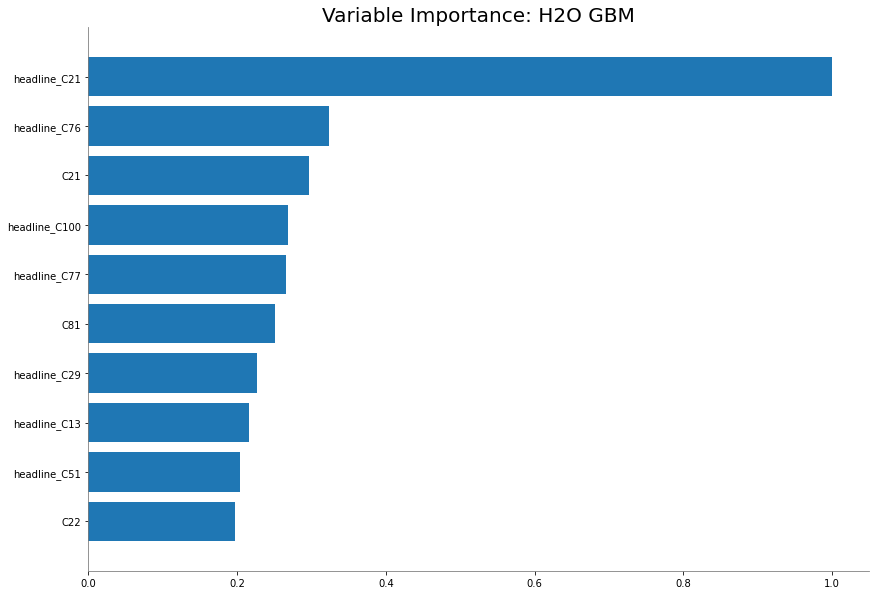

In [104]:
#### variance plot
gbm_all_cols_baseline_model.varimp_plot()

In [107]:
#### Tune model for hyper parameters

gbm_all_cols_baseline_model_hyperparameters = H2OGradientBoostingEstimator(ntrees=100,
                                                                           max_depth=6,
                                                                           learn_rate=0.1)

In [108]:
gbm_all_cols_baseline_model_hyperparameters.train(x=headline_vectors.names+review_vectors.names+['votes'],
                                                  y='target', 
                                                  training_frame=h2o_train, 
                                                  validation_frame=h2o_valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [109]:
print('hyper parameter AUC: '+ str(round(gbm_all_cols_baseline_model_hyperparameters.auc(valid=True),3)))

hyper parameter AUC: 0.949


In [110]:
gbm_all_cols_baseline_model_hyperparameters.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5438764330246593: 


,,0,1,Error,Rate
0,0,3560.0,1072.0,0.2314,(1072.0/4632.0)
1,1,708.0,11824.0,0.0565,(708.0/12532.0)
2,Total,4268.0,12896.0,0.1037,(1780.0/17164.0)


In [111]:
gbm_all_cols_baseline_model_hyperparameters.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-10 22:16:03,0.014 sec,0.0,0.445560,0.586333,0.500000,0.726884,1.000000,0.273116,0.443903,0.583153,0.500000,0.730133,1.000000,0.269867
1,,2020-11-10 22:16:04,1.365 sec,1.0,0.429954,0.552909,0.857827,0.939110,1.370413,0.192133,0.428756,0.550807,0.848949,0.936454,1.364146,0.195642
2,,2020-11-10 22:16:05,2.547 sec,2.0,0.416604,0.526106,0.870575,0.944211,1.370391,0.175131,0.415836,0.524885,0.862336,0.941731,1.364120,0.184805
3,,2020-11-10 22:16:06,3.733 sec,3.0,0.403979,0.501783,0.890098,0.952752,1.370969,0.160629,0.403700,0.501519,0.881089,0.949762,1.365103,0.164938
4,,2020-11-10 22:16:11,8.386 sec,7.0,0.368296,0.435094,0.911632,0.962353,1.373193,0.141738,0.370548,0.439008,0.900022,0.958252,1.367704,0.150431
5,,2020-11-10 22:16:16,13.080 sec,11.0,0.344432,0.390747,0.924401,0.968251,1.375735,0.129198,0.349042,0.398103,0.911876,0.963627,1.369614,0.141168
6,,2020-11-10 22:16:20,17.683 sec,15.0,0.327657,0.359592,0.932727,0.971949,1.375735,0.121990,0.334474,0.369999,0.919640,0.966814,1.362170,0.133594
7,,2020-11-10 22:16:25,22.505 sec,19.0,0.315238,0.336132,0.938502,0.974473,1.375735,0.115146,0.324085,0.349369,0.924642,0.968996,1.369614,0.129981
8,,2020-11-10 22:16:30,27.170 sec,23.0,0.305716,0.318107,0.942944,0.976437,1.375735,0.112065,0.316615,0.334181,0.928124,0.970369,1.361787,0.125903
9,,2020-11-10 22:16:34,31.778 sec,27.0,0.297544,0.302613,0.946931,0.978168,1.375735,0.107837,0.310628,0.321773,0.930923,0.971640,1.361651,0.124039


In [112]:
############## TRY With XGBoost ########
### instantiate XGBBoostEstimator
xgb_all_cols_model = H2OXGBoostEstimator(ntrees=100,
                                         learn_rate=0.1,
                                         max_leaves=6,
                                         tree_method='hist',
                                         grow_policy='lossguide')

In [113]:
### train with XGBoost
xgb_all_cols_model.train(x=headline_vectors.names+review_vectors.names+['votes'], y='target', training_frame=h2o_train, validation_frame=h2o_valid)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [115]:
print('XGBoost AUC: '+ str(round(xgb_all_cols_model.auc(valid=True),3)))

XGBoost AUC: 0.936


In [116]:
xgb_all_cols_model.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.549437007483314: 


,,0,1,Error,Rate
0,0,3318.0,1314.0,0.2837,(1314.0/4632.0)
1,1,729.0,11803.0,0.0582,(729.0/12532.0)
2,Total,4047.0,13117.0,0.119,(2043.0/17164.0)


In [117]:
##### Split datastets into 3 train, test and validation
h2o_train, h2o_valid, h2o_test = h2o_extended_with_headline_df.split_frame([.7,.15])

In [119]:
### instantiate GBMBoostEstimator
gbm_final_model = H2OGradientBoostingEstimator(ntrees=200,
                                         learn_rate=0.1,
                                         max_depth=6)

In [120]:
gbm_final_model.train(x=headline_vectors.names+review_vectors.names+['votes'], y='target', training_frame=h2o_train, validation_frame=h2o_valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [121]:
print('GBM Final model with 200 trees has AUC: '+ str(round(gbm_final_model.auc(valid=True),3)))

GBM Final model with 200 trees has AUC: 0.953


In [122]:
gbm_final_model.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5248070496106263: 


,,0,1,Error,Rate
0,0,2743.0,826.0,0.2314,(826.0/3569.0)
1,1,461.0,8797.0,0.0498,(461.0/9258.0)
2,Total,3204.0,9623.0,0.1003,(1287.0/12827.0)


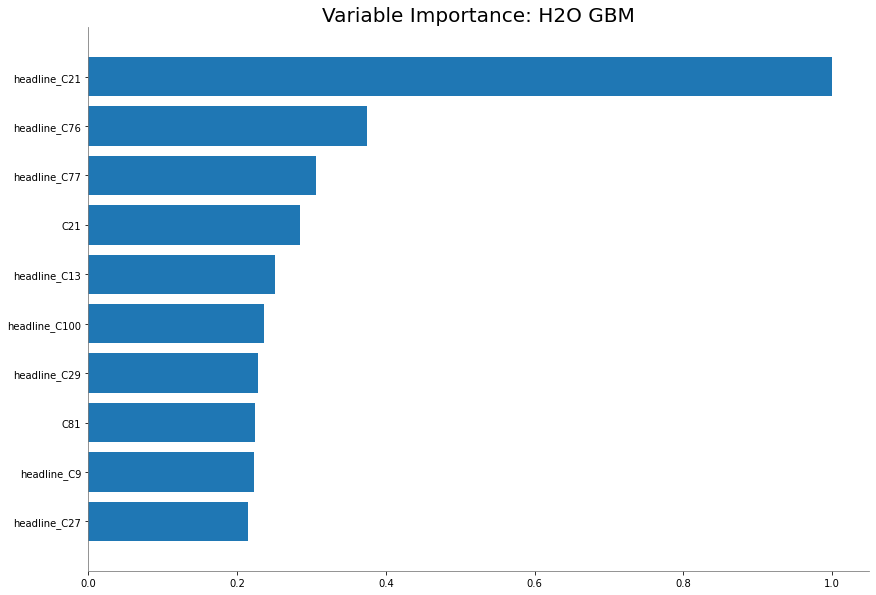

In [123]:
gbm_final_model.varimp_plot()

In [124]:
### let pass the test dataset and validta ethe performance of the model..
####using h2o_test dataset for prediction

gbm_final_model.model_performance(h2o_test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.07353849608222893
RMSE: 0.2711798224098337
LogLoss: 0.24132762524423856
Mean Per-Class Error: 0.1150489348282413
AUC: 0.9534010425682885
AUCPR: 0.9809029904155278
Gini: 0.906802085136577

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4603863340679368: 


,,0,1,Error,Rate
0,0,2605.0,949.0,0.267,(949.0/3554.0)
1,1,382.0,9055.0,0.0405,(382.0/9437.0)
2,Total,2987.0,10004.0,0.1025,(1331.0/12991.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.460386,0.931536,241.0
1,max f2,0.192732,0.957226,320.0
2,max f0point5,0.771758,0.939185,141.0
3,max accuracy,0.615438,0.899084,193.0
4,max precision,0.998461,1.000000,0.0
5,max recall,0.008948,1.000000,393.0
6,max specificity,0.998461,1.000000,0.0
7,max absolute_mcc,0.645428,0.746755,184.0
8,max min_per_class_accuracy,0.751987,0.883230,149.0
9,max mean_per_class_accuracy,0.771758,0.884951,141.0



Gains/Lift Table: Avg response rate: 72.64 %, avg score: 73.39 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011162,0.998265,1.376603,1.376603,1.000000,0.998477,1.000000,0.998477,0.015365,0.015365,37.660273,37.660273
1,,2,0.020014,0.998036,1.376603,1.376603,1.000000,0.998152,1.000000,0.998333,0.012186,0.027551,37.660273,37.660273
2,,3,0.030021,0.997803,1.376603,1.376603,1.000000,0.997915,1.000000,0.998194,0.013776,0.041327,37.660273,37.660273
3,,4,0.040028,0.997587,1.376603,1.376603,1.000000,0.997685,1.000000,0.998067,0.013776,0.055102,37.660273,37.660273
4,,5,0.050035,0.997339,1.376603,1.376603,1.000000,0.997451,1.000000,0.997944,0.013776,0.068878,37.660273,37.660273
5,,6,0.100069,0.996153,1.374485,1.375544,0.998462,0.996759,0.999231,0.997351,0.068772,0.137650,37.448488,37.554381
6,,7,0.150027,0.994474,1.372361,1.374484,0.996918,0.995386,0.998461,0.996697,0.068560,0.206210,37.236051,37.448380
7,,8,0.200062,0.992024,1.372367,1.373954,0.996923,0.993298,0.998076,0.995847,0.068666,0.274875,37.236703,37.395440
8,,9,0.300054,0.982958,1.366005,1.371305,0.992302,0.987948,0.996152,0.993215,0.136590,0.411466,36.600533,37.130539
9,,10,0.400046,0.966098,1.351169,1.366272,0.981524,0.975461,0.992496,0.988777,0.135106,0.546572,35.116897,36.627225
